In [83]:
from typing import Final
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from itertools import chain
from numba import njit, vectorize, guvectorize, int64, float64

%matplotlib inline

In [84]:
#pd.set_option('display.max_columns', None)

In [85]:
df = pd.read_excel('historyIndex.xls')
df = df.iloc[6:648].copy()

In [86]:
df.reset_index(drop=True, inplace=True)
df.columns = ['date', 'price']

In [87]:
df['date'] = pd.to_datetime(df['date'])
df = df.replace(',','', regex=True)
df['price'] = df['price'].astype(float)

In [88]:
periods = ['1m', '3m', '6m', '1y', '2y', '3y', '5y', '10y', '20y', '30y']
durations = [1, 3, 6, 12, 24, 36, 60, 120, 240, 360]

In [89]:
@njit
def calculate_return(ending_index, dca_length, onem_returns, investment_horizon=None):
    if investment_horizon is None:
        investment_horizon = dca_length
    elif investment_horizon < dca_length:
        raise ValueError('Investment horizon must be greater than or equal to DCA length')
    if ending_index < dca_length:
        return np.nan
    share_value = 0
    cash = 1
    for i in range(ending_index - investment_horizon, ending_index - investment_horizon + dca_length):
        cash -= 1/dca_length
        share_value += 1/dca_length
        share_value *= 1 + onem_returns[i+1]
    for i in range(ending_index - investment_horizon + dca_length, ending_index):
        share_value *= 1 + onem_returns[i+1]
    return share_value - 1

@guvectorize([(int64, int64, float64[:], int64, float64[:])], '(),(),(n),()->(n)', target='parallel', nopython=True)
def calculate_return_vector(n_rows, dca_length, onem_returns, investment_horizon, res=np.array([])):
    if investment_horizon < dca_length:
        raise ValueError('Investment horizon must be greater than or equal to DCA length')
    for i in range(n_rows):
        if i < investment_horizon:
            res[i] = np.nan
        share_value = 0
        cash = 1
        for j in range(i - investment_horizon, i - investment_horizon + dca_length):
            cash -= 1/dca_length
            share_value += 1/dca_length
            share_value *= 1 + onem_returns[j+1]
        for j in range(i - investment_horizon + dca_length, i):
            share_value *= 1 + onem_returns[j+1]
        res[i] = share_value - 1
        
@guvectorize([(float64, float64, float64, int64, int64, int64, float64[:], float64[:])], '(),(),(),(),(),(),(n)->(n)', target='parallel', nopython=True)
def calculate_lumpsum_return_with_fees_vector(total_investment, variable_fees, fixed_fees, dca_length, dca_interval, investment_horizon, onem_returns, res=np.array([])):
    if investment_horizon < dca_length:
        raise ValueError('Investment horizon must be greater than or equal to DCA length')
    if fixed_fees >= total_investment / dca_length * dca_interval:
        raise ValueError('Fixed fees must be less than the amount invested in each DCA')
    for i in range(len(onem_returns)):
        if i < investment_horizon:
            res[i] = np.nan
        share_value = 0
        cash = total_investment
        dca_amount = total_investment / dca_length * dca_interval
        for j in range(i - investment_horizon, i - investment_horizon + dca_length, dca_interval):
            cash -= dca_amount
            share_value += dca_amount * (1 - variable_fees) - fixed_fees
            for k in range(j, j + dca_interval):
                share_value *= 1 + onem_returns[k+1]
        if cash != 0.:
            share_value += cash * (1 - variable_fees) - fixed_fees
            cash-= cash
        for j in range(i - investment_horizon + dca_length, i):
            share_value *= 1 + onem_returns[j+1]
        res[i] = (share_value - total_investment) / total_investment
        
@guvectorize([(float64, float64, float64, int64, int64, float64[:], float64[:])], '(),(),(),(),(),(n)->(n)', target='parallel', nopython=True)
def calculate_dca_return_with_fees_vector(monthly_amount, variable_fees, fixed_fees, dca_length, dca_interval, onem_returns, res=np.array([])):
    total_investment = monthly_amount * dca_length
    dca_amount = monthly_amount * dca_interval
    if fixed_fees >= dca_amount:
        raise ValueError('Fixed fees must be less than the amount invested in each DCA')
    for i in range(len(onem_returns)):
        if i < dca_length:
            res[i] = np.nan
        share_value = 0
        amount_invested = 0
        for index, j in enumerate(range(i - dca_length, i)):
            if (index + 1) % dca_interval == 0:
                share_value += dca_amount * (1 - variable_fees) - fixed_fees
                amount_invested += dca_amount
            share_value *= 1 + onem_returns[j+1]
        res[i] = (share_value - amount_invested) / total_investment


In [90]:
for period, duration in zip(periods, durations):
    df[f'{period}_cumulative'] = df['price'].pct_change(periods=duration)
for period, duration in zip(periods, durations):
    df[f'{period}_annualized'] = (1 + df[f'{period}_cumulative'])**(12/duration) - 1
for period, duration in zip(periods, durations):
    df[f'{period}_dca_cumulative'] = calculate_return_vector(len(df), duration, df['1m_cumulative'].values, duration)
for period, duration in zip(periods, durations):
    df[f'{period}_dca_annualized'] = (1 + df[f'{period}_dca_cumulative'])**(12/duration) - 1
for period, duration in zip(periods, durations):
    df[f'{period}_cumulative_difference'] = df[f'{period}_cumulative'] - df[f'{period}_dca_cumulative']
for period, duration in zip(periods, durations):
    df[f'{period}_difference_in_annualized'] = df[f'{period}_annualized'] - df[f'{period}_dca_annualized']
df = pd.concat([df, pd.DataFrame.from_dict({f'{i}m_dca_{period}_cumulative': calculate_return_vector(len(df), i, df['1m_cumulative'].values, duration) for period, duration in zip(periods, durations) for i in range(1, duration+1)})], axis=1)

In [178]:
pd.DataFrame({f'every {dca_interval} months': calculate_dca_return_with_fees_vector(1000, 0.0002, 5.73, 120, dca_interval, df['1m_cumulative']) for dca_interval in range(1, 13)}).describe()

,every 1 months,every 2 months,every 3 months,every 4 months,every 5 months,every 6 months,every 7 months,every 8 months,every 9 months,every 10 months,every 11 months,every 12 months
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,0.521965,0.521560,0.518229,0.514155,0.509831,0.505390,0.500960,0.496141,0.491792,0.486888,0.482104,0.477577
std,0.426239,0.424275,0.421526,0.418579,0.415526,0.412458,0.409604,0.406468,0.403570,0.400074,0.397218,0.394085
min,-0.343158,-0.337823,-0.337497,-0.334394,-0.339838,-0.333575,-0.334131,-0.328696,-0.321344,-0.328248,-0.298722,-0.323919
25%,0.237834,0.239877,0.235557,0.236965,0.236470,0.235268,0.230296,0.228688,0.231747,0.223017,0.223466,0.231163
50%,0.427531,0.426840,0.428396,0.425524,0.421640,0.417192,0.407518,0.405476,0.409052,0.396662,0.393557,0.386008
75%,0.686403,0.682601,0.675947,0.668426,0.669067,0.649625,0.644807,0.635486,0.636328,0.621026,0.615592,0.598793
max,2.027456,2.024721,2.008309,2.006647,1.960483,1.967289,1.979136,1.960782,1.898864,1.905322,1.917443,1.905349


In [92]:
scaler = StandardScaler()

In [93]:
four_year_returns = pd.DataFrame.from_dict({f'{50000} invested over {dca_length} months every 3 months {48}-month return': calculate_lumpsum_return_with_fees_vector(50000, 0.0004, 5.73, dca_length, 3, 48, df['1m_cumulative'].values) for dca_length in range(3, 49, 3)})

In [94]:
four_year_returns.describe()

,50000 invested over 3 months every 3 months 48-month return,50000 invested over 6 months every 3 months 48-month return,50000 invested over 9 months every 3 months 48-month return,50000 invested over 12 months every 3 months 48-month return,50000 invested over 15 months every 3 months 48-month return,50000 invested over 18 months every 3 months 48-month return,50000 invested over 21 months every 3 months 48-month return,50000 invested over 24 months every 3 months 48-month return,50000 invested over 27 months every 3 months 48-month return,50000 invested over 30 months every 3 months 48-month return,50000 invested over 33 months every 3 months 48-month return,50000 invested over 36 months every 3 months 48-month return,50000 invested over 39 months every 3 months 48-month return,50000 invested over 42 months every 3 months 48-month return,50000 invested over 45 months every 3 months 48-month return,50000 invested over 48 months every 3 months 48-month return
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,0.355827,0.343202,0.330274,0.317670,0.305283,0.292942,0.280966,0.269229,0.257297,0.245738,0.233996,0.222474,0.211081,0.199868,0.188840,0.178070
std,0.438440,0.422566,0.407056,0.392465,0.378434,0.364728,0.351209,0.337785,0.324638,0.311768,0.298693,0.285465,0.272046,0.258529,0.244997,0.231420
min,-0.369925,-0.383505,-0.384535,-0.406803,-0.421037,-0.427187,-0.427250,-0.422316,-0.417755,-0.429624,-0.437950,-0.446084,-0.449147,-0.453482,-0.452869,-0.434594
25%,0.067470,0.071114,0.076453,0.091350,0.089945,0.097966,0.095085,0.085602,0.078361,0.072395,0.065859,0.057234,0.055834,0.049722,0.045603,0.040510
50%,0.304435,0.301655,0.286561,0.277159,0.266776,0.261187,0.248451,0.245157,0.240585,0.232163,0.222902,0.210439,0.199821,0.188719,0.180911,0.170364
75%,0.515293,0.511623,0.496192,0.469786,0.456332,0.440788,0.422002,0.411000,0.396409,0.382218,0.367453,0.353784,0.340296,0.323064,0.306635,0.288496
max,1.788567,1.751882,1.741733,1.767080,1.748622,1.737956,1.704903,1.657882,1.610887,1.550873,1.477419,1.400947,1.322007,1.256539,1.186021,1.116313


<Axes: >

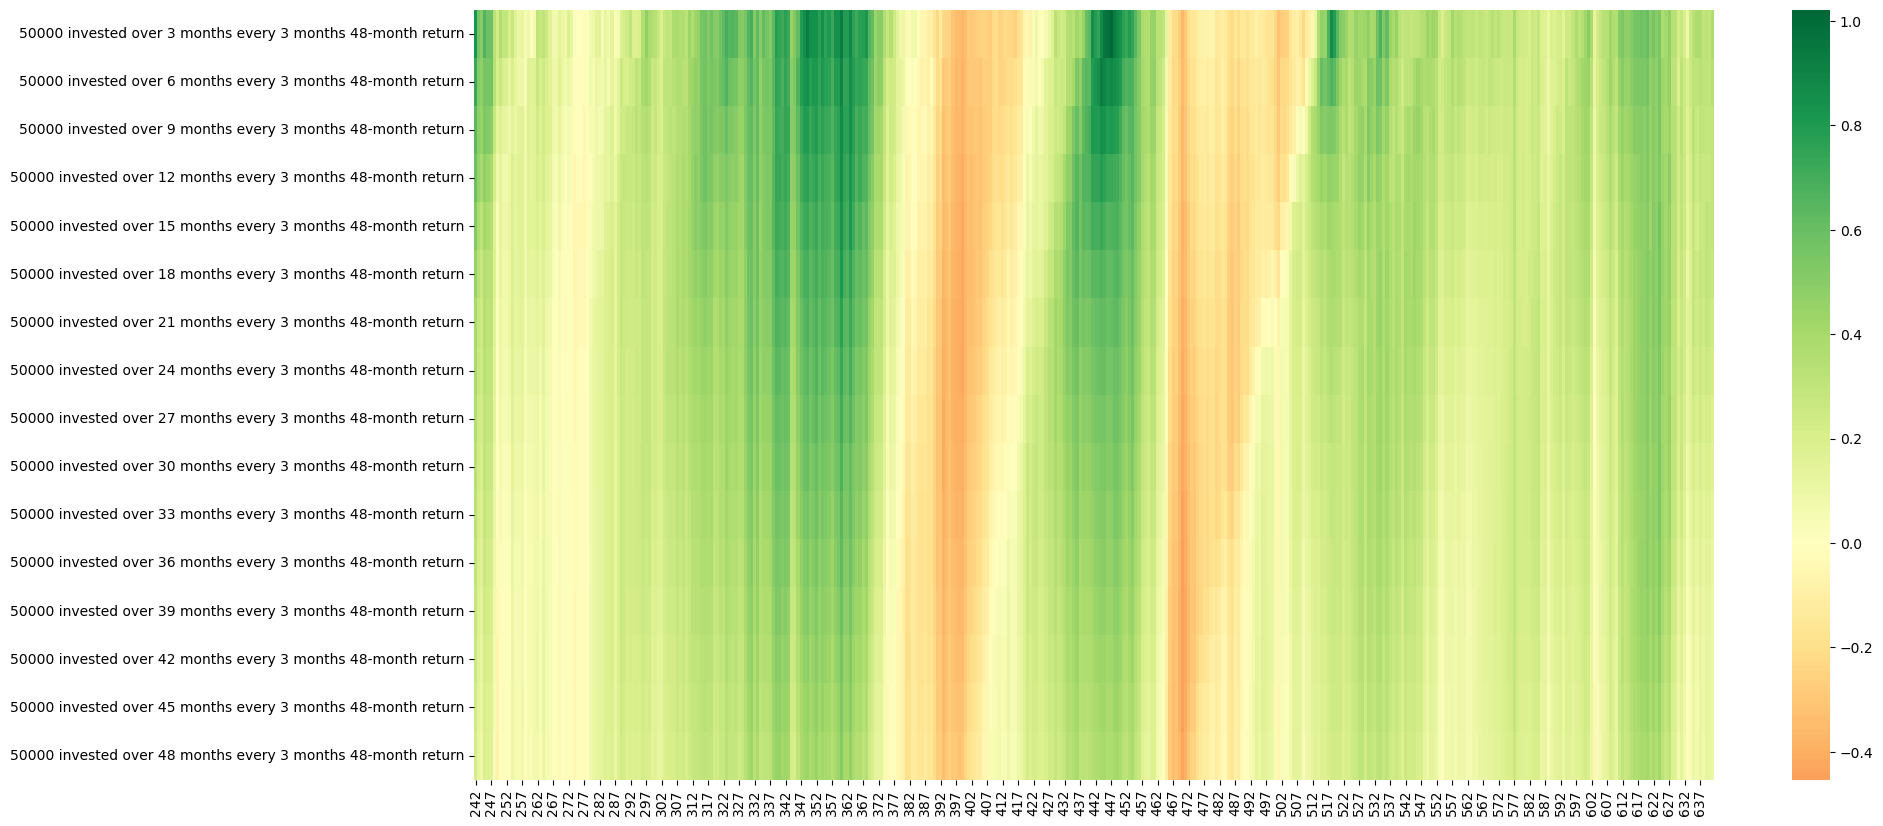

In [95]:
plt.figure(figsize=(20, 10))
sns.heatmap(four_year_returns.tail(400).T, cmap='RdYlGn', center=0)

In [96]:
df.head(10)

,date,price,1m_cumulative,3m_cumulative,6m_cumulative,1y_cumulative,2y_cumulative,3y_cumulative,5y_cumulative,10y_cumulative,...,351m_dca_30y_cumulative,352m_dca_30y_cumulative,353m_dca_30y_cumulative,354m_dca_30y_cumulative,355m_dca_30y_cumulative,356m_dca_30y_cumulative,357m_dca_30y_cumulative,358m_dca_30y_cumulative,359m_dca_30y_cumulative,360m_dca_30y_cumulative
0,1969-12-31,100.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1970-01-30,94.249,-0.057510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1970-02-27,96.979,0.028966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1970-03-31,97.075,0.000990,-0.029250,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1970-04-30,87.800,-0.095545,-0.068425,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1970-05-29,82.060,-0.065376,-0.153837,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1970-06-30,79.837,-0.027090,-0.177574,-0.201630,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1970-07-31,84.585,0.059471,-0.036617,-0.102537,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1970-08-31,87.175,0.030620,0.062332,-0.101094,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1970-09-30,89.788,0.029974,0.124641,-0.075066,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
df.describe()

,price,1m_cumulative,3m_cumulative,6m_cumulative,1y_cumulative,2y_cumulative,3y_cumulative,5y_cumulative,10y_cumulative,20y_cumulative,...,351m_dca_30y_cumulative,352m_dca_30y_cumulative,353m_dca_30y_cumulative,354m_dca_30y_cumulative,355m_dca_30y_cumulative,356m_dca_30y_cumulative,357m_dca_30y_cumulative,358m_dca_30y_cumulative,359m_dca_30y_cumulative,360m_dca_30y_cumulative
count,642.000000,641.000000,639.000000,636.000000,630.000000,618.000000,606.000000,582.000000,522.000000,402.000000,...,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,905.922877,0.006149,0.018925,0.039060,0.080740,0.170563,0.260451,0.467412,1.151401,3.536098,...,2.264285,2.257958,2.251655,2.245375,2.239119,2.232887,2.226676,2.220490,2.214326,2.208185
std,757.012612,0.043055,0.076845,0.114111,0.168147,0.261331,0.342168,0.534340,0.896151,2.418137,...,1.244644,1.241129,1.237628,1.234142,1.230671,1.227216,1.223778,1.220357,1.216955,1.213573
min,74.454000,-0.190451,-0.336046,-0.441680,-0.484141,-0.496214,-0.477192,-0.298613,-0.342114,0.293860,...,0.887948,0.885001,0.882060,0.879191,0.876292,0.873351,0.870368,0.867338,0.864339,0.861564
25%,169.662500,-0.018651,-0.017928,-0.026432,-0.017123,0.033003,0.090345,0.080935,0.499914,1.519582,...,1.359078,1.355021,1.350993,1.346978,1.343013,1.339242,1.335470,1.331885,1.328078,1.324390
50%,760.043000,0.009737,0.023132,0.041504,0.098377,0.184981,0.234882,0.399950,0.883492,2.987119,...,1.634248,1.629694,1.625145,1.620605,1.616284,1.611955,1.607703,1.603587,1.599429,1.595170
75%,1338.436500,0.030752,0.065026,0.102083,0.172651,0.311774,0.429476,0.663239,1.639192,5.247883,...,3.243607,3.234347,3.225123,3.215877,3.206645,3.197537,3.188502,3.179660,3.170879,3.162157
max,3231.727000,0.142656,0.291852,0.445802,0.624121,1.275536,1.779753,2.761887,3.633333,10.645654,...,6.530896,6.512901,6.494882,6.477093,6.459256,6.441533,6.423919,6.406438,6.388897,6.371372


In [98]:
df.loc[:,'1m_dca_30y_cumulative':]

,1m_dca_30y_cumulative,2m_dca_30y_cumulative,3m_dca_30y_cumulative,4m_dca_30y_cumulative,5m_dca_30y_cumulative,6m_dca_30y_cumulative,7m_dca_30y_cumulative,8m_dca_30y_cumulative,9m_dca_30y_cumulative,10m_dca_30y_cumulative,...,351m_dca_30y_cumulative,352m_dca_30y_cumulative,353m_dca_30y_cumulative,354m_dca_30y_cumulative,355m_dca_30y_cumulative,356m_dca_30y_cumulative,357m_dca_30y_cumulative,358m_dca_30y_cumulative,359m_dca_30y_cumulative,360m_dca_30y_cumulative
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,4.594235,4.534628,4.417845,4.304212,4.215330,4.164323,4.114873,4.052302,4.014143,3.971714,...,1.401237,1.397246,1.393282,1.389611,1.385736,1.382012,1.378619,1.375029,1.371264,1.367649
638,4.336574,4.194879,4.075855,3.991119,3.949924,3.907660,3.849084,3.816673,3.778575,3.775718,...,1.327749,1.323899,1.320336,1.316574,1.312958,1.309667,1.306182,1.302527,1.299018,1.295340
639,4.196273,4.085535,4.014037,3.990689,3.958415,3.902844,3.876689,3.842162,3.846867,3.828589,...,1.380877,1.377228,1.373373,1.369670,1.366301,1.362731,1.358987,1.355393,1.351624,1.347949
640,4.054085,4.001381,4.000611,3.977030,3.921364,3.900301,3.867943,3.879745,3.864043,3.822833,...,1.406957,1.403053,1.399303,1.395893,1.392280,1.388488,1.384849,1.381032,1.377310,1.373528


In [99]:
percentiles = df.loc[:,'1m_dca_30y_cumulative':'36m_dca_30y_cumulative'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1]).T.reset_index(drop=True)

In [100]:
percentiles.index += 1

In [101]:
percentiles

,0.00,0.05,0.25,0.50,0.75,0.95,1.00
1,2.810264,3.157185,4.580444,7.217149,9.316300,13.639771,16.256685
2,2.746638,3.134727,4.533824,7.254055,9.266619,13.661460,15.772352
3,2.735171,3.104699,4.490430,7.308514,9.289380,13.628568,15.487536
4,2.702695,3.102132,4.434840,7.304534,9.425637,13.670058,15.611398
5,2.669063,3.120069,4.389010,7.260017,9.558915,13.758385,15.674915
6,2.708827,3.105004,4.368715,7.200871,9.789438,13.767825,15.633432
7,2.740722,3.086630,4.321181,7.152534,9.894479,13.791718,15.535511
8,2.701841,3.097196,4.315955,7.095989,9.858379,13.718221,15.496491
9,2.681661,3.100592,4.299400,7.043554,9.926770,13.563041,15.430685
10,2.656386,3.139740,4.286906,7.021676,9.865103,13.428040,15.306238


In [102]:
px.line(percentiles.iloc[:,0], log_y=True)

In [103]:
df.loc[:, [*df.loc[:,'1m_annualized':'30y_annualized'].columns, *df.loc[:,'1m_dca_annualized':'30y_dca_annualized']]].describe()

,1m_annualized,3m_annualized,6m_annualized,1y_annualized,2y_annualized,3y_annualized,5y_annualized,10y_annualized,20y_annualized,30y_annualized,1m_dca_annualized,3m_dca_annualized,6m_dca_annualized,1y_dca_annualized,2y_dca_annualized,3y_dca_annualized,5y_dca_annualized,10y_dca_annualized,20y_dca_annualized,30y_dca_annualized
count,641.000000,639.000000,636.000000,630.000000,618.000000,606.000000,582.000000,522.000000,402.000000,282.000000,641.000000,639.000000,636.000000,630.000000,618.000000,606.000000,582.000000,522.000000,402.000000,282.000000
mean,0.203831,0.113903,0.092646,0.080740,0.075138,0.071600,0.069705,0.071448,0.071300,0.071215,0.203831,0.069463,0.051149,0.043406,0.039540,0.037989,0.038197,0.040196,0.039509,0.037594
std,0.600929,0.322819,0.235035,0.168147,0.121100,0.096383,0.072258,0.044334,0.028787,0.014104,0.600929,0.220629,0.144272,0.099250,0.070855,0.056960,0.043182,0.027323,0.019442,0.011654
min,-0.920765,-0.805665,-0.688279,-0.484141,-0.290221,-0.194410,-0.068481,-0.041008,0.012965,0.045599,-0.920765,-0.699196,-0.517853,-0.363117,-0.253669,-0.179262,-0.097822,-0.040590,-0.003443,0.020930
25%,-0.202227,-0.069806,-0.052166,-0.017123,0.016367,0.029251,0.015687,0.041374,0.047289,0.058983,-0.202227,-0.053354,-0.022327,-0.008486,0.006189,0.010165,0.012553,0.022173,0.023675,0.028514
50%,0.123308,0.095787,0.084730,0.098377,0.088568,0.072857,0.069603,0.065360,0.071600,0.072731,0.123308,0.069160,0.055105,0.053517,0.051205,0.044322,0.036802,0.036852,0.033916,0.032299
75%,0.438307,0.286594,0.214587,0.172651,0.145327,0.126486,0.107110,0.101911,0.095940,0.080896,0.438307,0.193303,0.137297,0.100485,0.078829,0.068728,0.060270,0.054276,0.060534,0.048682
max,3.954358,1.785167,1.090343,0.624121,0.508488,0.406054,0.303410,0.165707,0.130598,0.099593,3.954358,1.034034,0.554156,0.353810,0.274798,0.241228,0.181874,0.117805,0.076876,0.068854


In [104]:
go.Figure(
    data = [
        go.Box(
            x=df[column],
            name=column,
            )
        for column in chain.from_iterable(zip(df.loc[:,'1m_annualized':'30y_annualized'].columns, df.loc[:,'1m_dca_annualized':'30y_dca_annualized']))
    ],
    layout = go.Layout(
        height=800,
        xaxis=dict(
            tickformat='.2%',
        )
    )
)

In [105]:
go.Figure(
    [
        go.Scatter(
            x=df['date'],
            y=df[column],
            name=column,
            mode='lines'
            )
        for column in ['5y_annualized', '5y_dca_annualized']
    ]
)

In [106]:
go.Figure(
    [
        go.Scatter(
            x=df['date'],
            y=df[column],
            name=column,
            mode='lines'
            )
        for column in ['10y_annualized', '10y_dca_annualized']
    ]
)

In [107]:
go.Figure(
    [
        go.Scatter(
            x=df['date'],
            y=df[column],
            name=column,
            mode='lines'
            )
        for column in ['20y_annualized', '20y_dca_annualized']
    ]
)

In [108]:
go.Figure(
    [
        go.Box(
            x=df[column],
            name=column,
            opacity=0.75
            )
        for column in df.loc[:, '1m_difference_in_annualized':'30y_difference_in_annualized'].columns
    ],
    layout = go.Layout(
        xaxis=dict(
            tickformat='.0%',
        )
    )
)

In [109]:
df['1y_cumulative'].describe()

count    630.000000
mean       0.080740
std        0.168147
min       -0.484141
25%       -0.017123
50%        0.098377
75%        0.172651
max        0.624121
Name: 1y_cumulative, dtype: float64